# Starting

In [1]:
import numpy as np
import torch
import random
import pandas as pd
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [2]:
!pip install ultralytics wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.4 MB/s eta 0:00:0000:01


### Exploring data

In [3]:
# path = '/kaggle/input/amini-cocoa-contamination-dataset/dataset'
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ohagwucollinspatrick/amini-cocoa-contamination-dataset")

print("Path to dataset files:", path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


100%|██████████| 9.43G/9.43G [01:26<00:00, 117MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ohagwucollinspatrick/amini-cocoa-contamination-dataset/versions/1


In [4]:
%ls -l $path

total 1008
-rw-r--r-- 1 root root  68804 May  5 11:56 SampleSubmission.csv
-rw-r--r-- 1 root root  90427 May  5 11:56 Test.csv
-rw-r--r-- 1 root root 863669 May  5 11:56 Train.csv
drwxr-xr-x 4 root root   4096 May  5 11:56 dataset/


In [5]:
train_df = pd.read_csv(f'{path}/Train.csv').dropna()
test_df = pd.read_csv(f'{path}/Test.csv')
sample_submission = pd.read_csv(f'{path}/SampleSubmission.csv')

In [6]:
train_df.shape, test_df.shape

((9792, 9), (1626, 9))

In [7]:
display(train_df.head()), train_df[[ 'class_id']].value_counts()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_nBgcAR.jpg,healthy,1.0,75.0,15.0,162.0,195.0,2,dataset/images/train/ID_nBgcAR.jpg
1,ID_nBgcAR.jpg,healthy,1.0,58.0,1.0,133.0,171.0,2,dataset/images/train/ID_nBgcAR.jpg
2,ID_nBgcAR.jpg,healthy,1.0,42.0,29.0,377.0,349.0,2,dataset/images/train/ID_nBgcAR.jpg
3,ID_Kw2v8A.jpg,healthy,1.0,112.0,124.0,404.0,341.0,2,dataset/images/train/ID_Kw2v8A.jpg
4,ID_Kw2v8A.jpg,healthy,1.0,148.0,259.0,413.0,412.0,2,dataset/images/train/ID_Kw2v8A.jpg


(None,
 class_id
 2           4279
 1           3224
 0           2289
 Name: count, dtype: int64)

In [8]:
train_df[[ 'class']].value_counts()

class      
healthy        4280
cssvd          3241
anthracnose    2271
Name: count, dtype: int64

- there are 19 unclear values, we drop them for now.

In [9]:
train_df = train_df[
    (train_df['class'] == 'healthy') & (train_df['class_id'] == 2) |
    (train_df['class'] == 'cssvd') & (train_df['class_id'] == 1) |
    (train_df['class'] == 'anthracnose') & (train_df['class_id'] == 0)
]

### Emulating A6000 to work as T4
- we can use the A6000 as a T4 by setting the following parameters:
  - `--fp16` to enable half-precision floating point
  - `--fp16-opt-level` to set the optimization level for half-precision
  - `--no-mps-fp16` to disable MPS (Metal Performance Shaders) for half-precision
  - `--no-mps` to disable MPS entirely

In [10]:
import torch
#Emulating A6000 to work as T4
torch.cuda.set_device(0)
torch.cuda.set_per_process_memory_fraction(0.33, device=0)


In [14]:
!nvidia-smi 

Mon May  5 12:03:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:00:05.0 Off |                  Off |
| 30%   34C    P8             18W /  300W |     267MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### samples visualization

In [15]:
class_mapper = {
    2 : 'healthy',
    1 : 'cssvd',
    0 : 'anthracnose'
}

In [11]:
if False:
    import os
    import shutil
    from PIL import Image, ImageDraw
    import matplotlib.pyplot as plt
    import random

    # Paths for labels and images
    train_labels_path = os.path.join(path, "labels", 'train')
    train_images_path = os.path.join(path, "images", 'train')
    
    text_offset = 10  # Offset for text visibility
    n_rows, n_cols = 4, 3
    # Iterate through each class and process images
    for CLASS, cname in class_mapper.items():
        processed_images = 0
    
        # Prepare a subplot grid (e.g., n_rows rows and n_cols columns)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
        axes = axes.ravel()  # Flatten the axes array to iterate easily
        fig.suptitle(f"Class {CLASS} {class_mapper[CLASS]}: {cname} images", fontsize=16, weight='bold')
    
        # Loop over all images in the training images directory
        SHUFFELED_train_images_path = random.sample(os.listdir(train_images_path), len(os.listdir(train_images_path)))
        for image_file in SHUFFELED_train_images_path:
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(train_labels_path, label_file)
            image_path = os.path.join(train_images_path, image_file)
    
            # Skip if label file does not exist
            if not os.path.exists(label_path):
                continue
    
            # Read and filter label file for the specific class
            with open(label_path, 'r') as f:
                lines = [line.strip().split() for line in f if int(line.strip().split()[0]) == CLASS]
    
            # If there are bounding boxes for this class, process the image
            if lines:
                img = Image.open(image_path)
                draw = ImageDraw.Draw(img)
    
                # Process each bounding box in the label file
                for line in lines:
                    class_id, x_center, y_center, width, height = map(float, line)
                    img_width, img_height = img.size
    
                    # Convert YOLO format (normalized) to pixel coordinates
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height
    
                    # Compute bounding box corners
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
    
                    # Draw the bounding box and label on the image
                    draw.rectangle([x_min, y_min, x_max, y_max], outline="black", width=10)
                    draw.text((x_min, y_min - text_offset), f"Class {class_mapper[CLASS]}", fill="black")
    
                # Display the processed image in the subplot
                if processed_images < n_rows * n_cols:  # Ensure we only display up to 6 images
                    ax = axes[processed_images]
                    ax.imshow(img)
                    ax.axis('off')
                    ax.set_title(f"Image {processed_images + 1}")
    
                    processed_images += 1
    
            # Limit processing to a maximum of n_rows * n_cols images per class (n_rows rows, n_cols columns grid)
            if processed_images >= n_rows * n_cols:
                break
    
        # Adjust layout for the subplot
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for the big title
        plt.show()

### Yolo baseline

#### Yaml documentation for yolo

In [12]:
if False:
    import yaml
    
    # Define the content for the YAML file
    data = {
        'path': '/kaggle/input/amini-cocoa-contamination-dataset/dataset',
        'train': '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/train',
        'val': '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test',  # Assuming test is used for validation
        'test': '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test',
        'nc': 3,  # Number of classes
        'names': {
            2: 'healthy',
            1: 'cssvd',
            0: 'anthracnose'
        },
        'epochs': 50,
        'imgsz': 640
    }
    
    # Define the file path for the YAML file
    yaml_file_path = 'data.yaml'
    
    # Write the YAML content to a file
    with open(yaml_file_path, 'w') as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)
    
    print(f"YAML file created at {yaml_file_path}")


#### Implementing Cross-Validation + yaml documentation for yolo

In [17]:
import os
import random
import shutil
import yaml
from sklearn.model_selection import KFold 

# Path to the dataset
train_images_path = f'{path}/dataset/images/train'
train_labels_path = f'{path}/dataset/labels/train'
output_dir = '/kaggle/working/kfold_output'  # Output directory to store K-folds

# Number of folds
k = 5

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get the list of image and label filenames
image_files = sorted(os.listdir(train_images_path))
label_files = sorted(os.listdir(train_labels_path))

# Ensure that images and labels correspond
assert len(image_files) == len(label_files), "Mismatch between images and labels"

# Create K-fold splits using sklearn
kf = KFold(n_splits=k, shuffle=True, random_state=42)
DATA_SPLITS = kf.split(image_files)

- Loop through each fold and create the corresponding YAML file
- we are going to overwrite the fold data each time to not run out of storage

In [18]:
import os
import shutil
import yaml
import wandb
from ultralytics import YOLO

def create_dir_structure(base_path):
    dirs = {
        'train_images': os.path.join(base_path, 'train/images'),
        'train_labels': os.path.join(base_path, 'train/labels'),
        'val_images': os.path.join(base_path, 'val/images'),
        'val_labels': os.path.join(base_path, 'val/labels')
    }
    # Clear and recreate structure
    if os.path.exists(base_path):
        shutil.rmtree(base_path)
    for path in dirs.values():
        os.makedirs(path, exist_ok=True)
    return dirs

def copy_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.copy2(os.path.join(src_dir, file), dest_dir)

WARNING ⚠️ user config directory '/root/.config/Ultralytics' is not writeable, defaulting to '/tmp' or CWD.Alternatively you can define a YOLO_CONFIG_DIR environment variable for this path.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/tmp/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [15]:
if False:
    for fold, (train_indices, val_indices) in enumerate(DATA_SPLITS, 1):
        print(f"\n🔁 Starting Fold {fold}...")
    
        fold_dir = os.path.join(output_dir, 'fold')  # same folder reused
        dirs = create_dir_structure(fold_dir)
    
        train_image_files = [image_files[i] for i in train_indices]
        train_label_files = [label_files[i] for i in train_indices]
        val_image_files = [image_files[i] for i in val_indices]
        val_label_files = [label_files[i] for i in val_indices]
    
        copy_files(train_image_files, train_images_path, dirs['train_images'])
        copy_files(train_label_files, train_labels_path, dirs['train_labels'])
        copy_files(val_image_files, train_images_path, dirs['val_images'])
        copy_files(val_label_files, train_labels_path, dirs['val_labels'])
    
        # YAML config
        yaml_data = {
            'path': fold_dir,
            'train': os.path.join(fold_dir, 'train'),
            'val': os.path.join(fold_dir, 'val'),
            'test': '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test',
            'nc': 3,
            'names': {2: 'healthy', 1: 'cssvd', 0: 'anthracnose'},
            'epochs': 50,
            'imgsz': 320
        }
    
        yaml_path = os.path.join(fold_dir, 'data.yaml')
        with open(yaml_path, 'w') as f:
            yaml.dump(yaml_data, f, default_flow_style=False)
    
        print(f"✅ Fold {fold}: YAML created at {yaml_path}")
    
        # W&B setup
        wandb.init(project="cocoa-contamination", name=f"fold_{fold}", reinit=True)
    
        model = YOLO("yolov8n.pt")
    
        model.train(
            data=yaml_path,
            epochs=10,
            batch=16,
            imgsz=320,
            device=1,
            project='cocoa-contamination',
            name=f'anomaly-focused-training-FOLD{fold}'
        )
    
        wandb.finish()


In [16]:
import shutil
from IPython.display import FileLink

if False:
    # 1️⃣  Create the ZIP archive (lands in /kaggle/working)
    src_dir = "/kaggle/working/runs/detect/train"
    zip_path = "yolo-train-100ep-10124.zip"
    shutil.make_archive(base_name=zip_path.replace(".zip", ""), format="zip", root_dir=src_dir)
    
    # 2️⃣  Generate a clickable download link right in the notebook
    FileLink(zip_path)


In [ ]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("WBtoken")


In [13]:
import wandb
wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: youssef-ghaoui (ghaoui-ensi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

#### Evaluating cv

In [19]:
if False:
    import pandas as pd
    
    # Load the uploaded CSV files to inspect their contents
    file_paths = [ rf"/kaggle/working/cocoa-contamination/anomaly-focused-training-FOLD{f}/results.csv" for f in range(1, 6)
    ]
    
    # Read all the CSV files into DataFrames
    dataframes = [pd.read_csv(file_path) for file_path in file_paths]
    
    # Check the first few rows of each DataFrame to understand the structure
    [df.head() for df in dataframes]


In [20]:
if False:
    # Extract the mAP50 values from all the DataFrames and compute the final mean
    mAP50_values = [df['metrics/mAP50(B)'] for df in dataframes]
    
    # Flatten the list of mAP50 values and compute the mean
    all_mAP50_values = [value for sublist in mAP50_values for value in sublist]
    final_mAP50 = sum(all_mAP50_values) / len(all_mAP50_values)
    
    final_mAP50


In [21]:
if False:
    # Let's extract the fold-specific mAP50 values and identify the fold with the highest mAP50.
    # We'll compare the mAP50 values across the different files (folds) and determine the best one.
    
    mAP50_per_fold = {}
    
    # Iterate through each fold's data and capture the max mAP50 value
    for i, df in enumerate(dataframes):
        max_mAP50 = df['metrics/mAP50(B)'].max()
        mAP50_per_fold[f"Fold {i+1}"] = max_mAP50
    
    # Find the fold with the highest mAP50 value
    best_fold = max(mAP50_per_fold, key=mAP50_per_fold.get)
    best_mAP50_value = mAP50_per_fold[best_fold]
    
    best_fold, best_mAP50_value


### Training on best fold

In [14]:
DATA_SPLITS_LIST = list(DATA_SPLITS)
second_fold_indices = DATA_SPLITS_LIST[1]
second_fold_indices

(array([   0,    1,    2, ..., 5524, 5525, 5526]),
 array([  14,   19,   24, ..., 5523, 5527, 5528]))

In [15]:
top_train_indices, top_val_indices = second_fold_indices
top_train_indices, top_val_indices

(array([   0,    1,    2, ..., 5524, 5525, 5526]),
 array([  14,   19,   24, ..., 5523, 5527, 5528]))

In [16]:
    # dirs = create_dir_structure(fold_dir)
    
    train_image_files = [image_files[i] for i in top_train_indices]
    train_label_files = [label_files[i] for i in top_train_indices]
    val_image_files = [image_files[i] for i in top_val_indices]
    val_label_files = [label_files[i] for i in top_val_indices]

In [17]:
TOP_FOLD =2
    
fold_dir = os.path.join(output_dir, 'fold')  # same folder reused
if False:
    dirs = create_dir_structure(fold_dir)
    
    train_image_files = [image_files[i] for i in top_train_indices]
    train_label_files = [label_files[i] for i in top_train_indices]
    val_image_files = [image_files[i] for i in top_val_indices]
    val_label_files = [label_files[i] for i in top_val_indices]
    
    
    
    if not (os.listdir(dirs['train_images']) and os.listdir(dirs['train_labels']) and os.listdir(dirs['val_labels']) and os.listdir(dirs['val_labels'])):
            print(f"\n🔁 Starting TOP Fold {TOP_FOLD}...")
            copy_files(train_image_files, train_images_path, dirs['train_images'])
            copy_files(train_label_files, train_labels_path, dirs['train_labels'])
            copy_files(val_image_files, train_images_path, dirs['val_images'])
            copy_files(val_label_files, train_labels_path, dirs['val_labels'])
        
    # YAML config
yaml_data = {
    'path': fold_dir,
    'train': os.path.join(fold_dir, 'train'),
    'val': os.path.join(fold_dir, 'val'),
    'test': '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test',
    'nc': 3,
    'names': {2: 'healthy', 1: 'cssvd', 0: 'anthracnose'},
}

yaml_path = os.path.join(fold_dir, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

print(f"✅ Fold {TOP_FOLD}: YAML created at {yaml_path}")

✅ Fold 2: YAML created at /kaggle/working/kfold_output/fold/data.yaml


In [26]:
if False:
    import os
    import torch
    from pathlib import Path
    from torchvision import transforms
    from PIL import Image
    import pandas as pd
    import os
    import shutil
    import yaml
    import wandb
    from ultralytics import YOLO
    
    TOP_FOLD =2
    fold_dir = os.path.join(output_dir, 'fold')  # same folder reused
    yaml_path = os.path.join(fold_dir, 'data.yaml')
    model = YOLO(rf"cocoa-contamination/anomaly-focused-training-TOP-FOLD2-10244/weights/best.pt")
    model.train(
        data=yaml_path,
        epochs=40,
        batch=16,
        imgsz=1024,
        device=1,
        project='cocoa-contamination',
        name=f'anomaly-focused-training-TOP-FOLD-1024-session2'
    )
    
    wandb.finish()

# You can run all above, remove condition from cell above for training

### Submission

In [ ]:
model.eval()

In [35]:
import os
import torch
from pathlib import Path
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import shutil
import yaml
import wandb
from ultralytics import YOLO
# Path to the test images
test_dir = '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test'

model = YOLO('cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG8/weights/best.pt')#("runs/detect/train/weights/best.pt")
model.eval()

# Class names for your problem
class_names = {2: 'healthy', 1: 'cssvd', 0: 'anthracnose'}

# Get list of all test images
test_images = [os.path.join(test_dir, p) for p in os.listdir(test_dir)]  # Modify for other formats if needed


In [36]:
test_images

['/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_MNV5lc.jpg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_czKe5P.jpeg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_mirK4L.JPG',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_PQ3ccq.jpg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_LqD6nA.jpeg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_li2g5F.jpeg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_cF0WSr.jpg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_gxJl1S.jpg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_d0hoEZ.jpg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_XMbiwv.jpg',
 '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_B6Bi68.jpg',
 '/kaggle/input/amini-cocoa-contamination-dataset/d

In [ ]:

# Prepare the DataFrame to store the results
results = []

# Function to make predictions and store them in the required format
def predict_and_store(image_path):
    # Make predictions with the YOLO model
    with torch.no_grad():
        predictionsM = model(image_path)
    predictions = predictionsM[0]
    # Process predictions (this step handles Results object correctly)
    # Note: 'predictions' is now a Results object, so we can directly access boxes, labels, and scores.
    boxes = predictions.boxes.xyxy  # Bounding box coordinates (xyxy format)
    labels = predictions.boxes.cls  # Predicted class labels
    scores = predictions.boxes.conf  # Confidence scores
    
    # Iterate through the predictions for each box
    for box, label, score in zip(boxes, labels, scores):
        # Extract bounding box coordinates
        xmin, ymin, xmax, ymax = box.tolist()
        
        # Get the predicted class name
        class_name = class_names[label.item()]
        
        # Get the confidence score
        confidence = score.item()
        
        # Add this prediction to the results list
        image_name = os.path.basename(image_path)
        results.append([image_name, class_name, confidence, ymin, xmin, ymax, xmax])

# Predict for all test images
for img_path in test_images:
    predict_and_store(img_path)

# Convert results to DataFrame
df = pd.DataFrame(results, columns=['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax'])

# # Save the DataFrame as CSV for submission
# df.to_csv('submission-baseline.csv', index=False)

# print("Submission file created: submission.csv")



image 1/1 /kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_MNV5lc.jpg: 1024x768 1 cssvd, 47.1ms
Speed: 5.1ms preprocess, 47.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_czKe5P.jpeg: 768x1024 1 healthy, 46.2ms
Speed: 5.8ms preprocess, 46.2ms inference, 1.6ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_mirK4L.JPG: 1024x768 5 healthys, 12.5ms
Speed: 6.1ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 768)

image 1/1 /kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_PQ3ccq.jpg: 768x1024 1 cssvd, 12.3ms
Speed: 4.4ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test/ID_LqD6nA.jpeg: 1024x768 1 cssvd, 12.5ms
Speed:

In [40]:
df

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_MNV5lc.jpg,cssvd,0.773905,21.362381,32.985077,1218.171387,885.060547
1,ID_czKe5P.jpeg,healthy,0.536944,24.144823,918.349976,3022.647217,3580.174805
2,ID_mirK4L.JPG,healthy,0.570818,1106.917603,845.223694,1865.873291,1580.472778
3,ID_mirK4L.JPG,healthy,0.387754,1645.976807,774.762085,2422.477783,1357.491699
4,ID_mirK4L.JPG,healthy,0.298876,1672.497437,45.563118,2251.743896,471.436584
...,...,...,...,...,...,...,...
2533,ID_D99Mnd.jpg,cssvd,0.256655,0.581039,529.750244,232.284225,1175.522827
2534,ID_rkz8cy.jpg,anthracnose,0.518796,118.619232,242.499710,3911.040283,2649.393799
2535,ID_sVtcQI.jpeg,cssvd,0.602997,20.948729,819.794250,3024.000000,2947.153076
2536,ID_v6mMNG.jpg,cssvd,0.478929,71.603775,517.205139,2586.830322,1654.795776


In [ ]:
sample_submission

In [ ]:
len(sample_submission.Image_ID.unique()), len(df.Image_ID.unique())

In [ ]:
missing_ids.columns[3:]

In [39]:
missing_ids = sample_submission[~sample_submission['Image_ID'].isin(df['Image_ID'])].reset_index(drop=True)
missing_ids['class'] = None
missing_ids

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_ksM9yC.JPG,None,0.5,100,100,100,100
1,ID_s2Jw6Z.jpg,None,0.5,100,100,100,100
2,ID_wBzpKl.JPG,None,0.5,100,100,100,100
3,ID_HiEYk8.jpg,None,0.5,100,100,100,100
4,ID_yUCeOK.JPG,None,0.5,100,100,100,100
...,...,...,...,...,...,...,...
133,ID_LhPlyT.jpeg,None,0.5,100,100,100,100
134,ID_cgUOgM.jpeg,None,0.5,100,100,100,100
135,ID_V4uHkL.jpeg,None,0.5,100,100,100,100
136,ID_qKOiUh.jpeg,None,0.5,100,100,100,100


In [41]:
df_concat = pd.concat([df, missing_ids], axis=0).reset_index(drop=True)
df_concat

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,ID_MNV5lc.jpg,cssvd,0.773905,21.362381,32.985077,1218.171387,885.060547
1,ID_czKe5P.jpeg,healthy,0.536944,24.144823,918.349976,3022.647217,3580.174805
2,ID_mirK4L.JPG,healthy,0.570818,1106.917603,845.223694,1865.873291,1580.472778
3,ID_mirK4L.JPG,healthy,0.387754,1645.976807,774.762085,2422.477783,1357.491699
4,ID_mirK4L.JPG,healthy,0.298876,1672.497437,45.563118,2251.743896,471.436584
...,...,...,...,...,...,...,...
2671,ID_LhPlyT.jpeg,None,0.500000,100.000000,100.000000,100.000000,100.000000
2672,ID_cgUOgM.jpeg,None,0.500000,100.000000,100.000000,100.000000,100.000000
2673,ID_V4uHkL.jpeg,None,0.500000,100.000000,100.000000,100.000000,100.000000
2674,ID_qKOiUh.jpeg,None,0.500000,100.000000,100.000000,100.000000,100.000000


In [42]:
df_concat.to_csv('submission_gradxx.csv', index=False)


## Best Score on Zindi
Achieved the best score on Zindi with the model `runs/detect/train/weights/best.pt` at a score of **0.66**.

## Validation Metrics on Notebook

| Class         | Images | Instances | Box P | Box R | mAP50 | mAP50-95 |
|---------------|--------|-----------|-------|-------|-------|----------|
| **all**       | 1106   | 1964      | 0.762 | 0.673 | 0.744 | 0.489    |
| **anthracnose** | 318    | 467       | 0.741 | 0.686 | 0.756 | 0.514    |
| **cssvd**      | 437    | 635       | 0.799 | 0.631 | 0.736 | 0.489    |
| **healthy**    | 351    | 862       | 0.745 | 0.702 | 0.738 | 0.464    |


## Confusion Matrix

The confusion matrix below shows the performance of the model on the validation set. From the matrix, we can observe that the majority of mistakes are caused by confusions between different classes, which could be potential areas for model improvement.

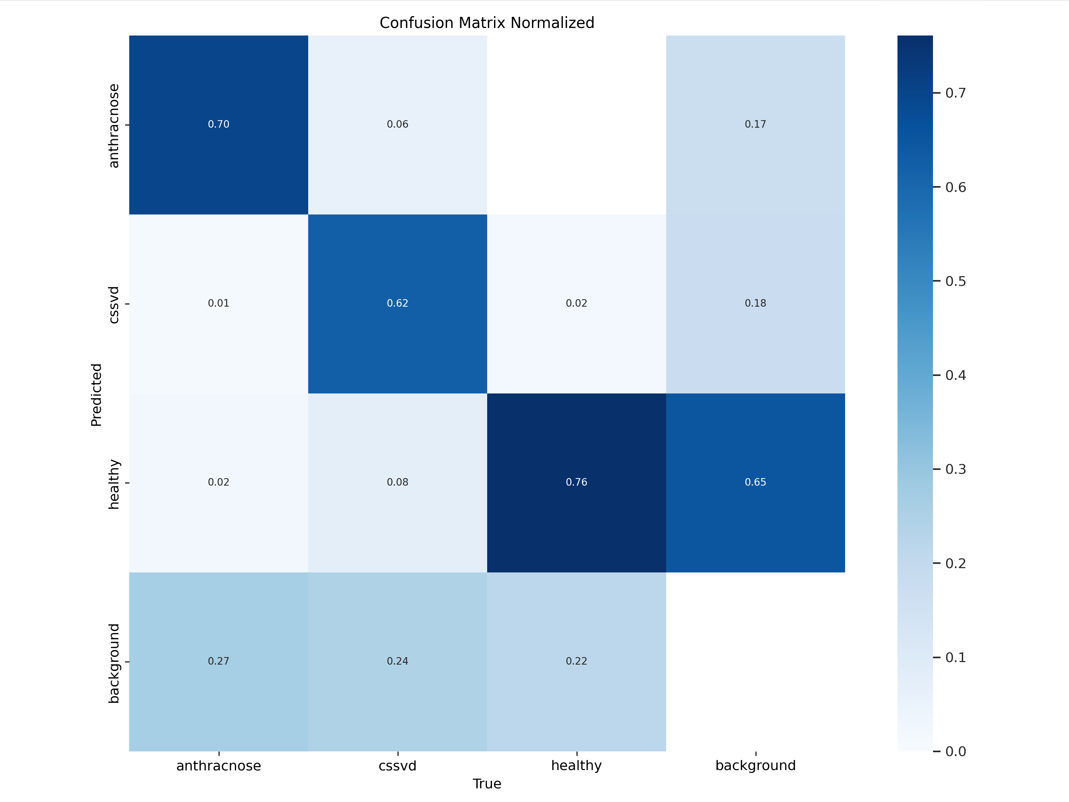


# **Improving the top model

### ploting some FP (healthy P, background N)

In [ ]:
val_image_files

In [ ]:
dirs['val_images']

In [ ]:
[os.path.join(dirs['val_images'], im) for im in os.listdir(dirs['val_images'])]

In [ ]:
results[0].cls

In [ ]:
cls = torch.tensor([1.], device='cuda:0')
class_mapper.get(int(cls), str(int(cls)))

In [ ]:
os.path.basename([os.path.join(val_image_dir, fn) for fn in os.listdir(val_image_dir)][0]).split('.')[0]+'.txt'

In [ ]:
random.sample(range(5), 3)

In [ ]:
import os
from pathlib import Path

import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from ultralytics import YOLO  # or your YOLO import


from PIL import Image, ImageFont, ImageDraw 
font = ImageFont.load_default(50)  

# Load the model
model = YOLO("runs/detect/train/weights/best.pt")

def load_image(image_path):
    return Image.open(image_path).convert("RGB")

def plot_predictions(image_files, label_dir, model, num_samples=5):
    text_offset = 12  # pixels above the box for the label

    for idx in random.sample(range(len(image_files)), num_samples):
        image_path = image_files[idx]
        label_path = os.path.basename(image_path).split('.')[0]+'.txt'
        label_path = os.path.join(label_dir, label_path)
        print(label_path, image_path)

        # Load and duplicate image for GT vs Pred
        orig     = load_image(image_path)
        img_pred = orig.copy()
        img_gt   = orig.copy()
        w, h     = orig.size

        draw_pred = ImageDraw.Draw(img_pred)
        draw_gt   = ImageDraw.Draw(img_gt)

        # --- draw predictions in red on img_pred ---
        results = model(image_path)
        print(results[0].boxes)
        for cls, box in zip(results[0].boxes.cls, results[0].boxes.xyxy):
            xmin, ymin, xmax, ymax = box.cpu().numpy().tolist()
            draw_pred.rectangle([xmin, ymin, xmax, ymax], outline="red", width=10)
            label = class_mapper.get(int(cls), str(int(cls)))
            draw_pred.text((xmin, ymin - text_offset), label, font = font, fill="black")

        # --- draw ground truth in green on img_gt ---
        with open(label_path, 'r') as f:
            for raw in f:
                print(raw)
                parts = raw.strip().split()
                cls, x_ctr, y_ctr, w_rel, h_rel = map(float, parts)

                # Convert normalized coords to pixel coords
                x_ctr *= w
                y_ctr *= h
                box_w = w_rel * w
                box_h = h_rel * h

                x_min = max(0, x_ctr - box_w/2)
                y_min = max(0, y_ctr - box_h/2)
                x_max = min(w, x_ctr + box_w/2)
                y_max = min(h, y_ctr + box_h/2)

                # Draw the box
                draw_gt.rectangle([x_min, y_min, x_max, y_max], outline="green", width=10)

                # Draw the class label
                label = class_mapper.get(int(cls), str(int(cls)))
                draw_gt.text((x_min, y_min - text_offset), label, font = font, fill="black")

        # --- plot side by side ---
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
        ax1.imshow(img_gt)
        ax1.set_title("Ground Truth")
        ax2.imshow(img_pred)
        ax2.set_title("Predictions")
        for ax in (ax1, ax2):
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage:
val_image_dir = dirs['val_images']
val_label_dir = dirs['val_labels']
image_files = [os.path.join(val_image_dir, fn) for fn in os.listdir(val_image_dir)]
label_files = [os.path.join(val_label_dir, fn) for fn in os.listdir(val_label_dir)]

plot_predictions(image_files, val_label_dir, model, num_samples=5)



In [ ]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/working/kfold_output/fold/val/images/ID_k90y45.jpg'
x = Image.open(image_path)

# Convert to numpy array
x_array = np.array(x)

# Reshape the image into 2D (height * width, channels)
height, width, channels = x_array.shape
flattened_image = x_array.reshape((height * width, channels))

# Standardize the data (zero mean, unit variance)
flattened_image = flattened_image - np.mean(flattened_image, axis=0)

# Apply PCA (using 2 components as an example, can be adjusted)
pca = PCA(n_components=2)  # You can adjust the number of components
principal_components = pca.fit_transform(flattened_image)

# Reconstruct the image using the principal components
reconstructed_image = pca.inverse_transform(principal_components)

# Reshape back to the original image shape
reconstructed_image = reconstructed_image.reshape((height, width, channels))

# Clip the values to ensure they are within the valid range [0, 255]
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

# Display the original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(x_array)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image)
axes[1].set_title('Reconstructed Image (PCA)')
axes[1].axis('off')

plt.show()


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/working/kfold_output/fold/val/images/ID_k90y45.jpg'
import cv2

def binarize_lib(image_file, thresh_val=127, with_plot=False, gray_scale=False):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    th, image_b = cv2.threshold(src=image_src, thresh=thresh_val, maxval=255, type=cv2.THRESH_BINARY)
    if with_plot:
        cmap_val = None if not gray_scale else 'gray'
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
        
        ax1.axis("off")
        ax1.title.set_text('Original')
        
        ax2.axis("off")
        ax2.title.set_text("Binarized")
        
        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_b, cmap=cmap_val)
        return image_b
    return image_b

In [ ]:
import numpy as np
import cv2
import json
from matplotlib import pyplot as plt


def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src
    

In [ ]:
b = binarize_lib(image_file=image_path, with_plot=True)


In [ ]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/working/kfold_output/fold/val/images/ID_k90y45.jpg'
x = Image.open(image_path)

# Convert to numpy array
x_array = np.array(x)

# Convert to grayscale
gray_image = cv2.cvtColor(x_array, cv2.COLOR_RGB2GRAY)

# Define the kernel for morphological operations
kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size as needed

# Apply dilation
dilated_image = cv2.dilate(gray_image, kernel, iterations=1)

# Apply erosion
eroded_image = cv2.erode(gray_image, kernel, iterations=1)

# Morphological Gradient (dilation - erosion)
gradient_image = dilated_image - eroded_image

# Display the original and gradient images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show the original image
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[0].axis('off')

# Show the gradient image
axes[1].imshow(gradient_image, cmap='gray')
axes[1].set_title('Morphological Gradient')
axes[1].axis('off')

plt.show()


In [ ]:
# Display the original and gradient images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show the original image
axes[0].imshow(gray_image + gradient_image, cmap='gray')
axes[0].set_title('Original Grayscale Image')
axes[0].axis('off')
# Show the gradient image
gradient_array = np.array(x_array)
gradient_array[:,:, 0], gradient_array[:,:, 1], gradient_array[:,:, 2] = gradient_image, gradient_image, gradient_image
axes[1].imshow(x_array + gradient_array, cmap='gray')
axes[1].set_title('Morphological Gradient')
axes[1].axis('off')

plt.show()

### Phase 2 : Training with Data Augmentation and Loss function tuning

#### Augmenting Data using base_image + gradient_image5x5

In [19]:
len(train_image_files), len(val_image_files)

(4423, 1106)

In [20]:
# Check if directories have files, if not, start the fold processing
if not (os.listdir(dirs['train_images']) and os.listdir(dirs['train_labels']) and os.listdir(dirs['val_labels']) and os.listdir(dirs['val_labels'])):
    print(f"\n🔁 Starting Augmented TOP Fold {TOP_FOLD}...")
else:
    print(f"\n🔁 Overriding Existing TOP Fold {TOP_FOLD} with Augmented one...")

# Process and copy files
copy_files(train_image_files, train_images_path, dirs['train_images'])
copy_files(train_label_files, train_labels_path, dirs['train_labels'])
copy_files(val_image_files, train_images_path, dirs['val_images'])
copy_files(val_label_files, train_labels_path, dirs['val_labels'])



🔁 Starting Augmented TOP Fold 2...


NameError: name 'Image' is not defined

In [30]:
len(os.listdir(dirs['train_images']))

1105

In [32]:
train_images_path

'/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/train'

In [35]:
if False:
    import numpy as np
    import cv2
    from PIL import Image
    import matplotlib.pyplot as plt
    # Now, let's process images and apply gradient morphology before copying to the final directories
    for idx, image_file in enumerate(train_image_files+val_image_files):
        if idx%1000==0:
            print(idx,'file done')
        image_path = os.path.join(train_images_path, image_file)
        x = Image.open(image_path)
    
        # Convert to numpy array
        x_array = np.array(x)
    
        # Convert to grayscale
        gray_image = cv2.cvtColor(x_array, cv2.COLOR_RGB2GRAY)
    
        # Define the kernel for morphological operations
        kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size as needed
    
        # Apply dilation and erosion
        dilated_image = cv2.dilate(gray_image, kernel, iterations=1)
        eroded_image = cv2.erode(gray_image, kernel, iterations=1)
    
        # Morphological Gradient (dilation - erosion)
        gradient_image = dilated_image - eroded_image
    
        # Create a gradient image with same shape as original
        gradient_array = np.array(x_array)
        gradient_array[:,:, 0], gradient_array[:,:, 1], gradient_array[:,:, 2] = gradient_image, gradient_image, gradient_image
    
        # Add the gradient to the original image (highlight edges)
        x_array = np.clip(x_array + gradient_array, 0, 255).astype(np.uint8)
    
        # Save the modified image
        modified_image = Image.fromarray(x_array)
        if idx>len(train_image_files):
            modified_image.save(os.path.join(dirs['train_images'], image_file))
        else:
            modified_image.save(os.path.join(dirs['val_images'], image_file))
    
    


0 file done
1000 file done
2000 file done
3000 file done
4000 file done
5000 file done
✅ Fold 2: YAML created at /kaggle/working/kfold_output/fold/data.yaml


**

In [25]:
import os
len(os.listdir('/kaggle/working/kfold_output/fold/val/images'))

5529

In [16]:
    # YAML config
    yaml_data = {
        'path': fold_dir,
        'train': os.path.join(fold_dir, 'train'),
        'val': os.path.join(fold_dir, 'val'),
        'test': '/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/test',
        'nc': 3,
        'names': {2: 'healthy', 1: 'cssvd', 0: 'anthracnose'},
    }
    
    yaml_path = os.path.join(fold_dir, 'data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_data, f, default_flow_style=False)
    
    print(f"✅ Fold {TOP_FOLD}: YAML created at {yaml_path}")

✅ Fold 2: YAML created at /kaggle/working/kfold_output/fold/data.yaml


In [23]:
torch.cuda

<module 'torch.cuda' from '/usr/local/lib/python3.11/dist-packages/torch/cuda/__init__.py'>

In [24]:
!nvidia-smi 

Wed Apr 30 15:03:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P0             29W /   70W |   14973MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [32]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [33]:
# Initialize wandb logging to track all metrics automatically.
wandb.init(
    project="zindi-yolo-training-COCOA-Grad",            # Replace with your wandb project name
)
# --------------------------------------------------
# 1)  load checkpoint ------------------------------
# --------------------------------------------------
# model = YOLO("runs/detect/train/weights/best.pt")
model = YOLO("cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG5/weights/best.pt")
# --------------------------------------------------
# 2)  fine-tune with built-in augs + tuned hypers --
# --------------------------------------------------
model.train(
    data="/kaggle/working/kfold_output/fold/data.yaml",
    epochs=100,                
    batch=16,  # Experimenting with larger batch size
    imgsz=1024,
    
    # ---------- strong built-in augmentations ----------
    hsv_h=0.015, hsv_s=0.70, hsv_v=0.40,  
    fliplr=1.0, flipud=0.10,               
    mosaic=0.9, copy_paste=0.3,           # Adjusted augmentation settings
    mixup=0.0,                            

    # ---------- hyper-parameter tweaks ----------
    box=5,    # Increased box weight
    cls=0.4,    # Decreased class weight slightly
    dfl=1.6,    # Slightly higher DFL weight
    # label_smoothing=0,                  # Turned off label smoothing

    # ---------- optimization ----------
    # lr0=0.001,    # Lower initial learning rate
    # lrf=0.01,      # Reduce learning rate over time
    patience=10,   # Early stopping after 10 epochs of no improvement
    device=device,
    project='cocoa-contamination',
    name=f'TOP-FOLD-1024-FT-Grad-Hyper-AUG',
    verbose=True
)


engine/trainer: task=detect, mode=train, model=cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG5/weights/best.pt, data=/kaggle/working/kfold_output/fold/data.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=cuda:1, workers=8, project=cocoa-contamination, name=TOP-FOLD-1024-FT-Grad-Hyper-AUG8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning /kaggle/working/kfold_output/fold/train/labels.cache... 4423 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4423/4423 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 653.7±410.8 MB/s, size: 843.8 KB)


val: Scanning /kaggle/working/kfold_output/fold/val/labels.cache... 1106 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1106/1106 [00:00<?, ?it/s]


Plotting labels to cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.01G     0.7691      1.014      1.819         32       1024: 100%|██████████| 277/277 [03:05<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:25<00:00,  1.40it/s]

                   all       1106       1964      0.713      0.575      0.638      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.98G     0.7851      1.032      1.839         38       1024: 100%|██████████| 277/277 [03:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


                   all       1106       1964      0.716      0.551      0.606      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.99G     0.8151      1.092      1.886         26       1024: 100%|██████████| 277/277 [03:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:24<00:00,  1.41it/s]


                   all       1106       1964      0.664      0.543      0.591      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.99G     0.8299      1.115      1.913         19       1024: 100%|██████████| 277/277 [02:58<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:25<00:00,  1.37it/s]


                   all       1106       1964      0.704      0.538      0.612      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.99G     0.8363      1.126      1.908         29       1024: 100%|██████████| 277/277 [03:00<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


                   all       1106       1964      0.702      0.566      0.618      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.99G     0.8294      1.121      1.913         18       1024: 100%|██████████| 277/277 [03:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:24<00:00,  1.42it/s]


                   all       1106       1964      0.674      0.517      0.554      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.99G     0.8324      1.116      1.915         23       1024: 100%|██████████| 277/277 [02:57<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:24<00:00,  1.42it/s]


                   all       1106       1964      0.663      0.556      0.604      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.99G     0.8195      1.091      1.894         29       1024: 100%|██████████| 277/277 [02:59<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:25<00:00,  1.36it/s]

                   all       1106       1964      0.687      0.584      0.617      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.99G     0.8266      1.116      1.906         14       1024: 100%|██████████| 277/277 [02:59<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:26<00:00,  1.33it/s]


                   all       1106       1964       0.65      0.563      0.615      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.99G     0.8221       1.09      1.892         28       1024: 100%|██████████| 277/277 [02:59<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:24<00:00,  1.40it/s]


                   all       1106       1964      0.701      0.562      0.618      0.358

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.99G     0.8109      1.087      1.879         25       1024: 100%|██████████| 277/277 [02:59<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


                   all       1106       1964      0.673      0.564      0.604      0.345
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

11 epochs completed in 0.632 hours.
Optimizer stripped from cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG8/weights/last.pt, 5.5MB
Optimizer stripped from cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG8/weights/best.pt, 5.5MB

Validating cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG8/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


                   all       1106       1964      0.713      0.574      0.638      0.374
           anthracnose        318        467      0.706      0.601      0.671      0.387
                 cssvd        437        635      0.757      0.631      0.706      0.448
               healthy        351        862      0.677      0.488      0.537      0.287


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 4.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to cocoa-contamination/TOP-FOLD-1024-FT-Grad-Hyper-AUG8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ebbb0e01190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
wandb.finish()


In [ ]:
    import os
    import torch
    from pathlib import Path
    from torchvision import transforms
    from PIL import Image
    import pandas as pd
    import os
    import shutil
    import yaml
    import wandb
    from ultralytics import YOLO
    
    TOP_FOLD =2
    model = YOLO(rf"/kaggle/working/cocoa-contamination/anomaly-focused-training-TOP-FOLD-1024-session22/weights/best.pt")
    model.train(
        data='/kaggle/working/kfold_output/fold/data.yaml',
        epochs=40,
        batch=16,
        imgsz=1024,
        device=1,
        # ---------- strong built-in augmentations ----------
        hsv_h=0.015, hsv_s=0.70, hsv_v=0.40,   # colour jitter
        fliplr=1.0, flipud=0.10,               # full horiz + some vert flips
        mosaic=1.0, copy_paste=0.50,           # context & object diversity
        mixup=0.0, 
        
        project='cocoa-contamination',
        name=f'anomaly-focused-training-TOP-FOLD-1024-session2'
    )
    
    wandb.finish()

In [1]:
from ultralytics import YOLO

# Path to the trained model and data.yaml file
model = YOLO("runs/detect/train/weights/best.pt")
data = '/kaggle/working/kfold_output/fold/data.yaml'

# Evaluate the model on the validation set
results = model.val(data=data)

# Print evaluation results
print(results)


Ultralytics 8.3.120 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 4.53MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1346.0±294.4 MB/s, size: 887.0 KB)



val: Scanning /kaggle/working/kfold_output/fold/val/labels... 1106 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1106/1106 [00:00<00:00, 1398.68it/s]


val: New cache created: /kaggle/working/kfold_output/fold/val/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:27<00:00,  2.53it/s]


                   all       1106       1964       0.52      0.459      0.397      0.216
           anthracnose        318        467      0.316      0.591      0.346      0.172
                 cssvd        437        635      0.787      0.441      0.572      0.342
               healthy        351        862      0.455      0.345      0.272      0.136


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.8ms preprocess, 6.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val4
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b56e9fa72d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,   

In [2]:
from ultralytics import YOLO

# Path to the trained model and data.yaml file
model = YOLO("cocoa-contamination/TOP-FOLD-1024-finetune-hyptuned-adjusted/weights/best.pt")
data = '/kaggle/working/kfold_output/fold/data.yaml'

# Evaluate the model on the validation set
results = model.val(data=data)

# Print evaluation results
print(results)

Ultralytics 8.3.120 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2603.3±1054.3 MB/s, size: 1053.6 KB)


val: Scanning /kaggle/working/kfold_output/fold/val/labels.cache... 1106 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1106/1106 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 70/70 [00:24<00:00,  2.84it/s]


                   all       1106       1964      0.074     0.0962     0.0683      0.039
           anthracnose        318        467     0.0426     0.0985     0.0451     0.0234
                 cssvd        437        635      0.102      0.113      0.104     0.0634
               healthy        351        862     0.0778     0.0766     0.0556     0.0301


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 6.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val5
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5633621550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,   

In [ ]:
    train_image_files = [image_files[i] for i in top_train_indices]
    train_label_files = [label_files[i] for i in top_train_indices]
    val_image_files = [image_files[i] for i in top_val_indices]
    val_label_files = [label_files[i] for i in top_val_indices]

In [23]:
len(val_image_files)

1106

In [ ]:
import os
import shutil
import yaml
import wandb
from ultralytics import YOLO

def create_dir_structure(base_path):
    dirs = {
        'train_images': os.path.join(base_path, 'train/images'),
        'train_labels': os.path.join(base_path, 'train/labels'),
        'val_images': os.path.join(base_path, 'val/images'),
        'val_labels': os.path.join(base_path, 'val/labels')
    }
    # Clear and recreate structure
    if os.path.exists(base_path):
        shutil.rmtree(base_path)
    for path in dirs.values():
        os.makedirs(path, exist_ok=True)
    return dirs

def copy_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.copy2(os.path.join(src_dir, file), dest_dir)

In [40]:
os.path.join(fold_dir, 'train')

'/kaggle/working/kfold_output/fold/train'

In [45]:
len(os.listdir(os.path.join(fold_dir, 'train', 'images'))), len(os.listdir(os.path.join(fold_dir, 'val', 'images')))

(4423, 1106)

Number of images in train/images: 4423
Number of images in val/images: 1106


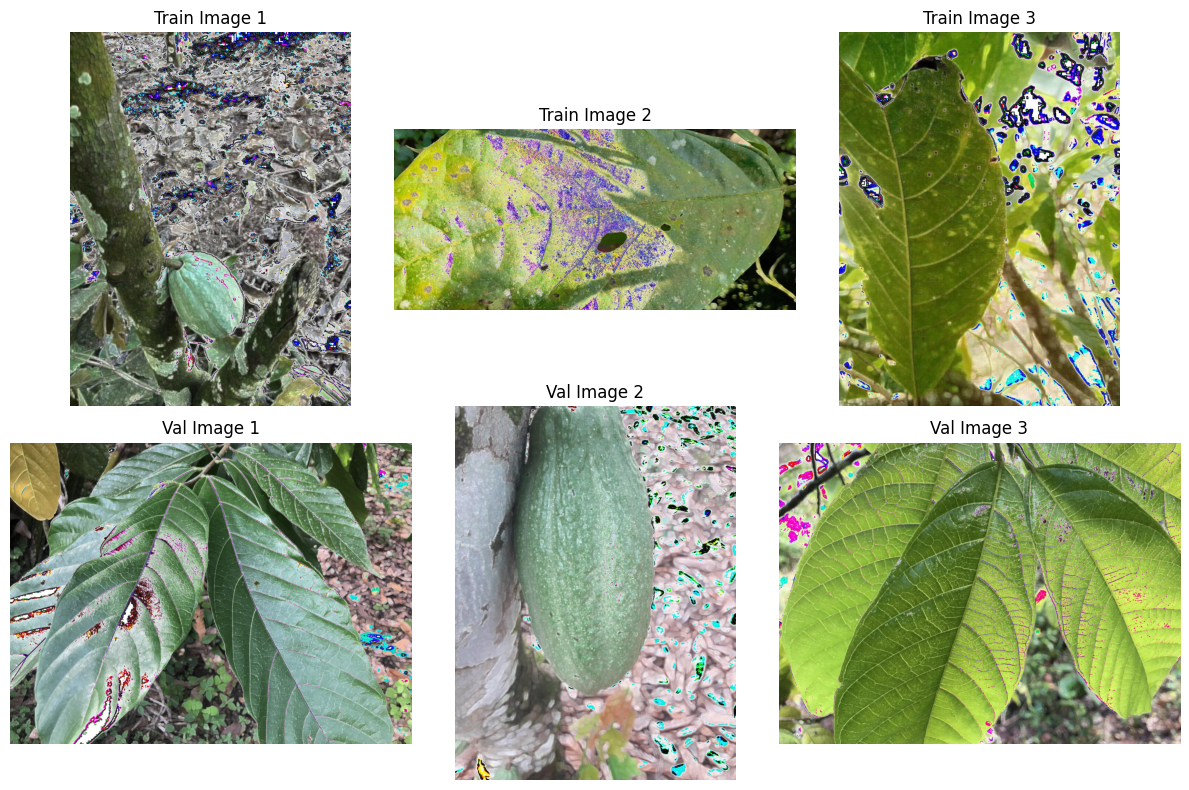

In [65]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List images in train/images and val/images directories
train_images = os.listdir(os.path.join(fold_dir, 'train', 'images'))
val_images = os.listdir(os.path.join(fold_dir, 'val', 'images'))

# Display the number of images in each directory
print(f"Number of images in train/images: {len(train_images)}")
print(f"Number of images in val/images: {len(val_images)}")

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Load and display 3 images from the 'train/images' directory
for i, ax in enumerate(axes[0, :]):
    img_path = os.path.join(fold_dir, 'train', 'images', train_images[i])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off axes for better image visibility
    ax.set_title(f'Train Image {i+1}')

# Load and display 3 images from the 'val/images' directory
for i, ax in enumerate(axes[1, :]):
    img_path = os.path.join(fold_dir, 'val', 'images', val_images[i])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off axes for better image visibility
    ax.set_title(f'Val Image {i+1}')

# Show the plot
plt.tight_layout()
plt.show()


In [31]:
train_df.Image_ID.nunique()

5516

In [32]:
shutil.rmtree(os.path.join(fold_dir, 'train'))

In [38]:
os.makedirs(os.path.join(fold_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(fold_dir, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(fold_dir, 'train/labels'), exist_ok=True)

In [43]:
import shutil
import os

def move_files(file_list, src_dir, dest_dir):
    for file in file_list:
        shutil.move(os.path.join(src_dir, file), dest_dir)


In [42]:
train_image_files

['ID_A0o1FA.jpeg',
 'ID_A1OsZt.jpeg',
 'ID_A397lM.jpg',
 'ID_A3ZjTJ.jpeg',
 'ID_A4KXll.jpg',
 'ID_A5PBJ2.jpeg',
 'ID_A5WiVe.jpg',
 'ID_A6p4R9.jpg',
 'ID_A8K8dv.jpg',
 'ID_A9j4mt.jpg',
 'ID_AA4r2M.jpg',
 'ID_AACxhu.jpg',
 'ID_AAJ1hf.jpg',
 'ID_AB0ZAJ.jpeg',
 'ID_ABkF66.jpg',
 'ID_AC3jGA.jpeg',
 'ID_ACAUuY.jpg',
 'ID_ADUP0r.JPG',
 'ID_AELiZ5.jpg',
 'ID_AGNleG.jpeg',
 'ID_AGRHMs.jpg',
 'ID_AGb8GD.jpg',
 'ID_AIj0R3.jpg',
 'ID_AJD939.jpg',
 'ID_AJf7yR.jpg',
 'ID_AK7dFo.jpeg',
 'ID_AMshRT.jpeg',
 'ID_ANT5S4.jpg',
 'ID_ANhQDr.jpg',
 'ID_ANjSRA.jpg',
 'ID_ANnwzq.jpg',
 'ID_AOGygM.jpeg',
 'ID_AObMlH.jpg',
 'ID_AOtnot.jpeg',
 'ID_APRODJ.jpg',
 'ID_ARDESe.jpg',
 'ID_ARV285.jpg',
 'ID_AS0DDf.jpg',
 'ID_ASOu9k.jpg',
 'ID_AUeDSo.jpg',
 'ID_AWKx5p.jpg',
 'ID_AWV6yV.jpeg',
 'ID_AWYI8j.jpeg',
 'ID_AYKor4.jpg',
 'ID_AYLNiX.jpeg',
 'ID_AYMzS9.JPG',
 'ID_Aa371T.jpg',
 'ID_Aa5Pam.jpeg',
 'ID_AbFM85.jpeg',
 'ID_AbHMqL.jpg',
 'ID_AcK0Lv.jpeg',
 'ID_AdO3kx.jpg',
 'ID_AeDRMO.jpg',
 'ID_Aer1qp.JPG',
 'ID_Af2WnK

In [28]:
len(os.listdir(os.path.join(fold_dir, 'train', 'labels'))), len(os.listdir(os.path.join(fold_dir, 'val', 'labels')))

(4423, 1106)

In [50]:

# move_files(train_image_files, os.path.join(fold_dir, 'val', 'images'), os.path.join(fold_dir, 'train/images'))


In [51]:
# copy_files(train_label_files, train_labels_path, os.path.join(fold_dir, 'train/labels'))


In [54]:
train_images_path

'/kaggle/input/amini-cocoa-contamination-dataset/dataset/images/train'

In [ ]:
train_labels_path = '/kaggle/input/amini-cocoa-contamination-dataset/dataset/labels/train'

In [55]:
shutil.rmtree(os.path.join(fold_dir, 'val'))
os.makedirs(os.path.join(fold_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(fold_dir, 'val/images'), exist_ok=True)
os.makedirs(os.path.join(fold_dir, 'val/labels'), exist_ok=True)

In [63]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
# Now, let's process images and apply gradient morphology before copying to the final directories
for idx, image_file in enumerate(val_image_files):
    if idx%100==0:
        print(idx,'file done')
    image_path = os.path.join(train_images_path, image_file)
    x = Image.open(image_path)

    # Convert to numpy array
    x_array = np.array(x)

    # Convert to grayscale
    gray_image = cv2.cvtColor(x_array, cv2.COLOR_RGB2GRAY)

    # Define the kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size as needed

    # Apply dilation and erosion
    dilated_image = cv2.dilate(gray_image, kernel, iterations=1)
    eroded_image = cv2.erode(gray_image, kernel, iterations=1)

    # Morphological Gradient (dilation - erosion)
    gradient_image = dilated_image - eroded_image

    # Create a gradient image with same shape as original
    gradient_array = np.array(x_array)
    gradient_array[:,:, 0], gradient_array[:,:, 1], gradient_array[:,:, 2] = gradient_image, gradient_image, gradient_image

    # Add the gradient to the original image (highlight edges)
    x_array = np.clip(x_array + gradient_array, 0, 255).astype(np.uint8)

    # Save the modified image
    modified_image = Image.fromarray(x_array)
    modified_image.save(os.path.join(os.path.join(fold_dir, 'val/images'), image_file))
    

0 file done
100 file done
200 file done
300 file done
400 file done
500 file done
600 file done
700 file done
800 file done
900 file done
1000 file done
1100 file done


In [56]:
val_label_files

['ID_ABiqqH.txt',
 'ID_AECW0W.txt',
 'ID_AH4rDM.txt',
 'ID_AIHFIo.txt',
 'ID_AKxhMY.txt',
 'ID_ALaJle.txt',
 'ID_ALv01N.txt',
 'ID_ASBvj5.txt',
 'ID_AWx5cy.txt',
 'ID_AXlzhG.txt',
 'ID_AZedrD.txt',
 'ID_AclybJ.txt',
 'ID_AfzFVc.txt',
 'ID_AiM8Ff.txt',
 'ID_AjfziN.txt',
 'ID_AqvsjF.txt',
 'ID_Aykxbw.txt',
 'ID_B05KfJ.txt',
 'ID_B1GBWw.txt',
 'ID_B2Bkib.txt',
 'ID_B5gUqH.txt',
 'ID_B6BwKf.txt',
 'ID_B6T938.txt',
 'ID_B71sn7.txt',
 'ID_BAKMFl.txt',
 'ID_BBs0vX.txt',
 'ID_BC1LIj.txt',
 'ID_BJOnhx.txt',
 'ID_BKWaOF.txt',
 'ID_BM1xwq.txt',
 'ID_BPV6ab.txt',
 'ID_BQih4N.txt',
 'ID_BS8889.txt',
 'ID_BXDY51.txt',
 'ID_BXg2hJ.txt',
 'ID_BZmL2Q.txt',
 'ID_BerVLr.txt',
 'ID_BfMggU.txt',
 'ID_BiTMni.txt',
 'ID_BsWVWD.txt',
 'ID_BuRQDQ.txt',
 'ID_BubVLr.txt',
 'ID_Bw9N5J.txt',
 'ID_BwXrSz.txt',
 'ID_Bx6k3i.txt',
 'ID_BxCnJ3.txt',
 'ID_C1Gqym.txt',
 'ID_C4UW0B.txt',
 'ID_C5dYqX.txt',
 'ID_C82AUP.txt',
 'ID_C9SxS3.txt',
 'ID_C9tBF7.txt',
 'ID_CGTYfy.txt',
 'ID_CRMgGx.txt',
 'ID_CYa4x1.txt',
 'ID_CZ8gq

In [59]:
# # Copy labels from train to val
# for label_file in val_label_files:
#     shutil.copy(os.path.join(train_labels_path, label_file), os.path.join(os.path.join(os.path.join(fold_dir, 'val/labels'), label_file)))


In [27]:
len(os.listdir(os.path.join(fold_dir, 'train', 'images'))), len(os.listdir(os.path.join(fold_dir, 'val', 'images')))

(4423, 1106)